pip install scikit-learn

pip install imblearn

In [1]:
import os
os.chdir('D:\yahel\phd\courses\ML in biology research\\final_project')
os.getcwd()

'd:\\yahel\\phd\\courses\\ML in biology research\\final_project'

In [2]:


import numpy as np
import pandas as pd
import random
import string
import pickle
import copy
import glob
from functools import partial
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold , train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin

from Diabetic_readmission_essentials import categorize_dia, calculate_ratio
from Diabetic_readmission_essentials import plotsEDA

from imblearn.over_sampling import SMOTENC

random.seed(42)
mpl.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\131536188.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# read database #
path_to_data = os.path.join('data', 'diabetic_data.csv')
whole_data_df = pd.read_csv(path_to_data)
whole_data_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Find for each feature the value it has
possibale_val_list = [whole_data_df[x].unique() for x in whole_data_df.columns]
possibale_val_df = pd.DataFrame(zip(list(whole_data_df.columns),possibale_val_list))
possibale_val_df

,0,1
0,encounter_id,"[2278392, 149190, 64410, 500364, 16680, 35754,..."
1,patient_nbr,"[8222157, 55629189, 86047875, 82442376, 425192..."
2,race,"[Caucasian, AfricanAmerican, ?, Other, Asian, ..."
3,gender,"[Female, Male, Unknown/Invalid]"
4,age,"[[0-10), [10-20), [20-30), [30-40), [40-50), [..."
5,weight,"[?, [75-100), [50-75), [0-25), [100-125), [25-..."
6,admission_type_id,"[6, 1, 2, 3, 4, 5, 8, 7]"
7,discharge_disposition_id,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1..."
8,admission_source_id,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22..."
9,time_in_hospital,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]"


#### Filter dataset for diabetic pateints diagnosed at least once 

In [5]:
# replace ?/None/Unknown/Invalid  with np.nan
whole_data_df[whole_data_df == "?"] = np.nan
whole_data_df[whole_data_df == "None"] = np.nan
whole_data_df[whole_data_df == "Unknown/Invalid"] = np.nan

# how many var and obs in data, data types and non -missing values
mis = whole_data_df.isna().sum()
whole_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
# pop out the features with 1 option only
for fiture in whole_data_df[whole_data_df.columns[2:]]:
    if len(set(whole_data_df[fiture])) == 1:
        whole_data_df.pop(fiture)
    elif mis[fiture] > len(whole_data_df):
        whole_data_df.pop(fiture)

In [7]:
diagnosis_cols_list = ['diag_' + str(num) for num in [1,2,3]]

# Regex pattern to locate diabeteic pateints 
pattern = r'250(\.\d{2})?'

# count diabetes diagnosis appearance  in all 3 daignosis columns 
diag_count = whole_data_df[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)

diabetic_only_df = whole_data_df[diag_count > 0]
print('%d encounters out of %d total encounters are of diabetic pateints \n i.e. ~ %.2f%% '\
    %(diabetic_only_df.shape[0],whole_data_df.shape[0],
      (diabetic_only_df.shape[0]/whole_data_df.shape[0])*100))

38024 encounters out of 101766 total encounters are of diabetic pateints 
 i.e. ~ 37.36% 


C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\668848931.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  diag_count = whole_data_df[diagnosis_cols_list].apply(lambda x: x.str.contains(pattern)).sum(axis =1)


### determine repeated encounter by the same patient

In [8]:
duplicated_encounters = sum(diabetic_only_df['patient_nbr'].duplicated())
print('%d encounters are patient repeated ones, ~%.2f%%' % \
    (duplicated_encounters,
    (duplicated_encounters/diabetic_only_df.shape[0]*100)))


print(diabetic_only_df['patient_nbr'].value_counts().value_counts())


6836 encounters are patient repeated ones, ~17.98%
count
1     26849
2      3091
3       750
4       242
5       114
6        55
7        31
8        14
10       10
11        9
9         7
15        4
12        2
14        2
17        2
28        1
13        1
18        1
19        1
22        1
38        1
Name: count, dtype: int64


In [9]:
calculate_ratio(diabetic_only_df['readmitted'])

readmitted
NO     0.547102
>30    0.343362
<30    0.109536
Name: count, dtype: float64

In [10]:
# an imbalanced label! 

# get the repeated patients readmission labels 
duplicated_df = diabetic_only_df[diabetic_only_df['patient_nbr'].duplicated()]
duplicated_df = duplicated_df[~duplicated_df['patient_nbr'].duplicated()]

# the precenatge of 
print('\n\nprecenatge of label classes beloning to repeated patients \n',duplicated_df['readmitted'].value_counts()/diabetic_only_df['readmitted'].value_counts())



precenatge of label classes beloning to repeated patients 
 readmitted
<30    0.163745
>30    0.147212
NO     0.083401
Name: count, dtype: float64


## Since a large portion of the encounters is a duplication of the same patient 
## We decided to treat each encounter as a different patient
## Therefore for test-train split we will follow the group_stratified split 

In [11]:
# stratify by pateints' ID as group 
groups_for_stratification = diabetic_only_df['patient_nbr']
X = diabetic_only_df.drop('readmitted',axis=1)
Y = diabetic_only_df['readmitted']

# instentiate the StratifiedGroupKFold class
sgkf = StratifiedGroupKFold(n_splits=5) 

# use the CV split to create 5 spilt of a 80-20 ratio
cv_division = sgkf.split(X, Y,groups_for_stratification)

# unpack the first one - randomly 
train_test_index_array, *_ = cv_division

train_df = diabetic_only_df.iloc[train_test_index_array[0]]
test_df = diabetic_only_df.iloc[train_test_index_array[1]]

display(pd.DataFrame({'Complete dataset' : calculate_ratio(diabetic_only_df['readmitted']),
                      'Train datset (80%)' : calculate_ratio(train_df['readmitted']),
                      'Test datset (20%)' : calculate_ratio(test_df['readmitted'])}))

print('There are %d pateint with overlap between train-test cohorts' % sum(np.in1d(train_df['patient_nbr'].unique(), test_df['patient_nbr'].unique())))

#if len(glob.glob('D:/yahel/phd/courses/ML in biology research/final_project/data/data_split*.csv')) == 0:
#    train_df.to_csv(os.path.join(os.getcwd(),'data','data_split','train_cohort.csv'))
#    test_df.to_csv(os.path.join(os.getcwd(),'data','data_split','test_cohort.csv'))

,Complete dataset,Train datset (80%),Test datset (20%)
readmitted,,,
NO,0.547102,0.547107,0.547080
>30,0.343362,0.343360,0.343372
<30,0.109536,0.109533,0.109548


There are 0 pateint with overlap between train-test cohorts


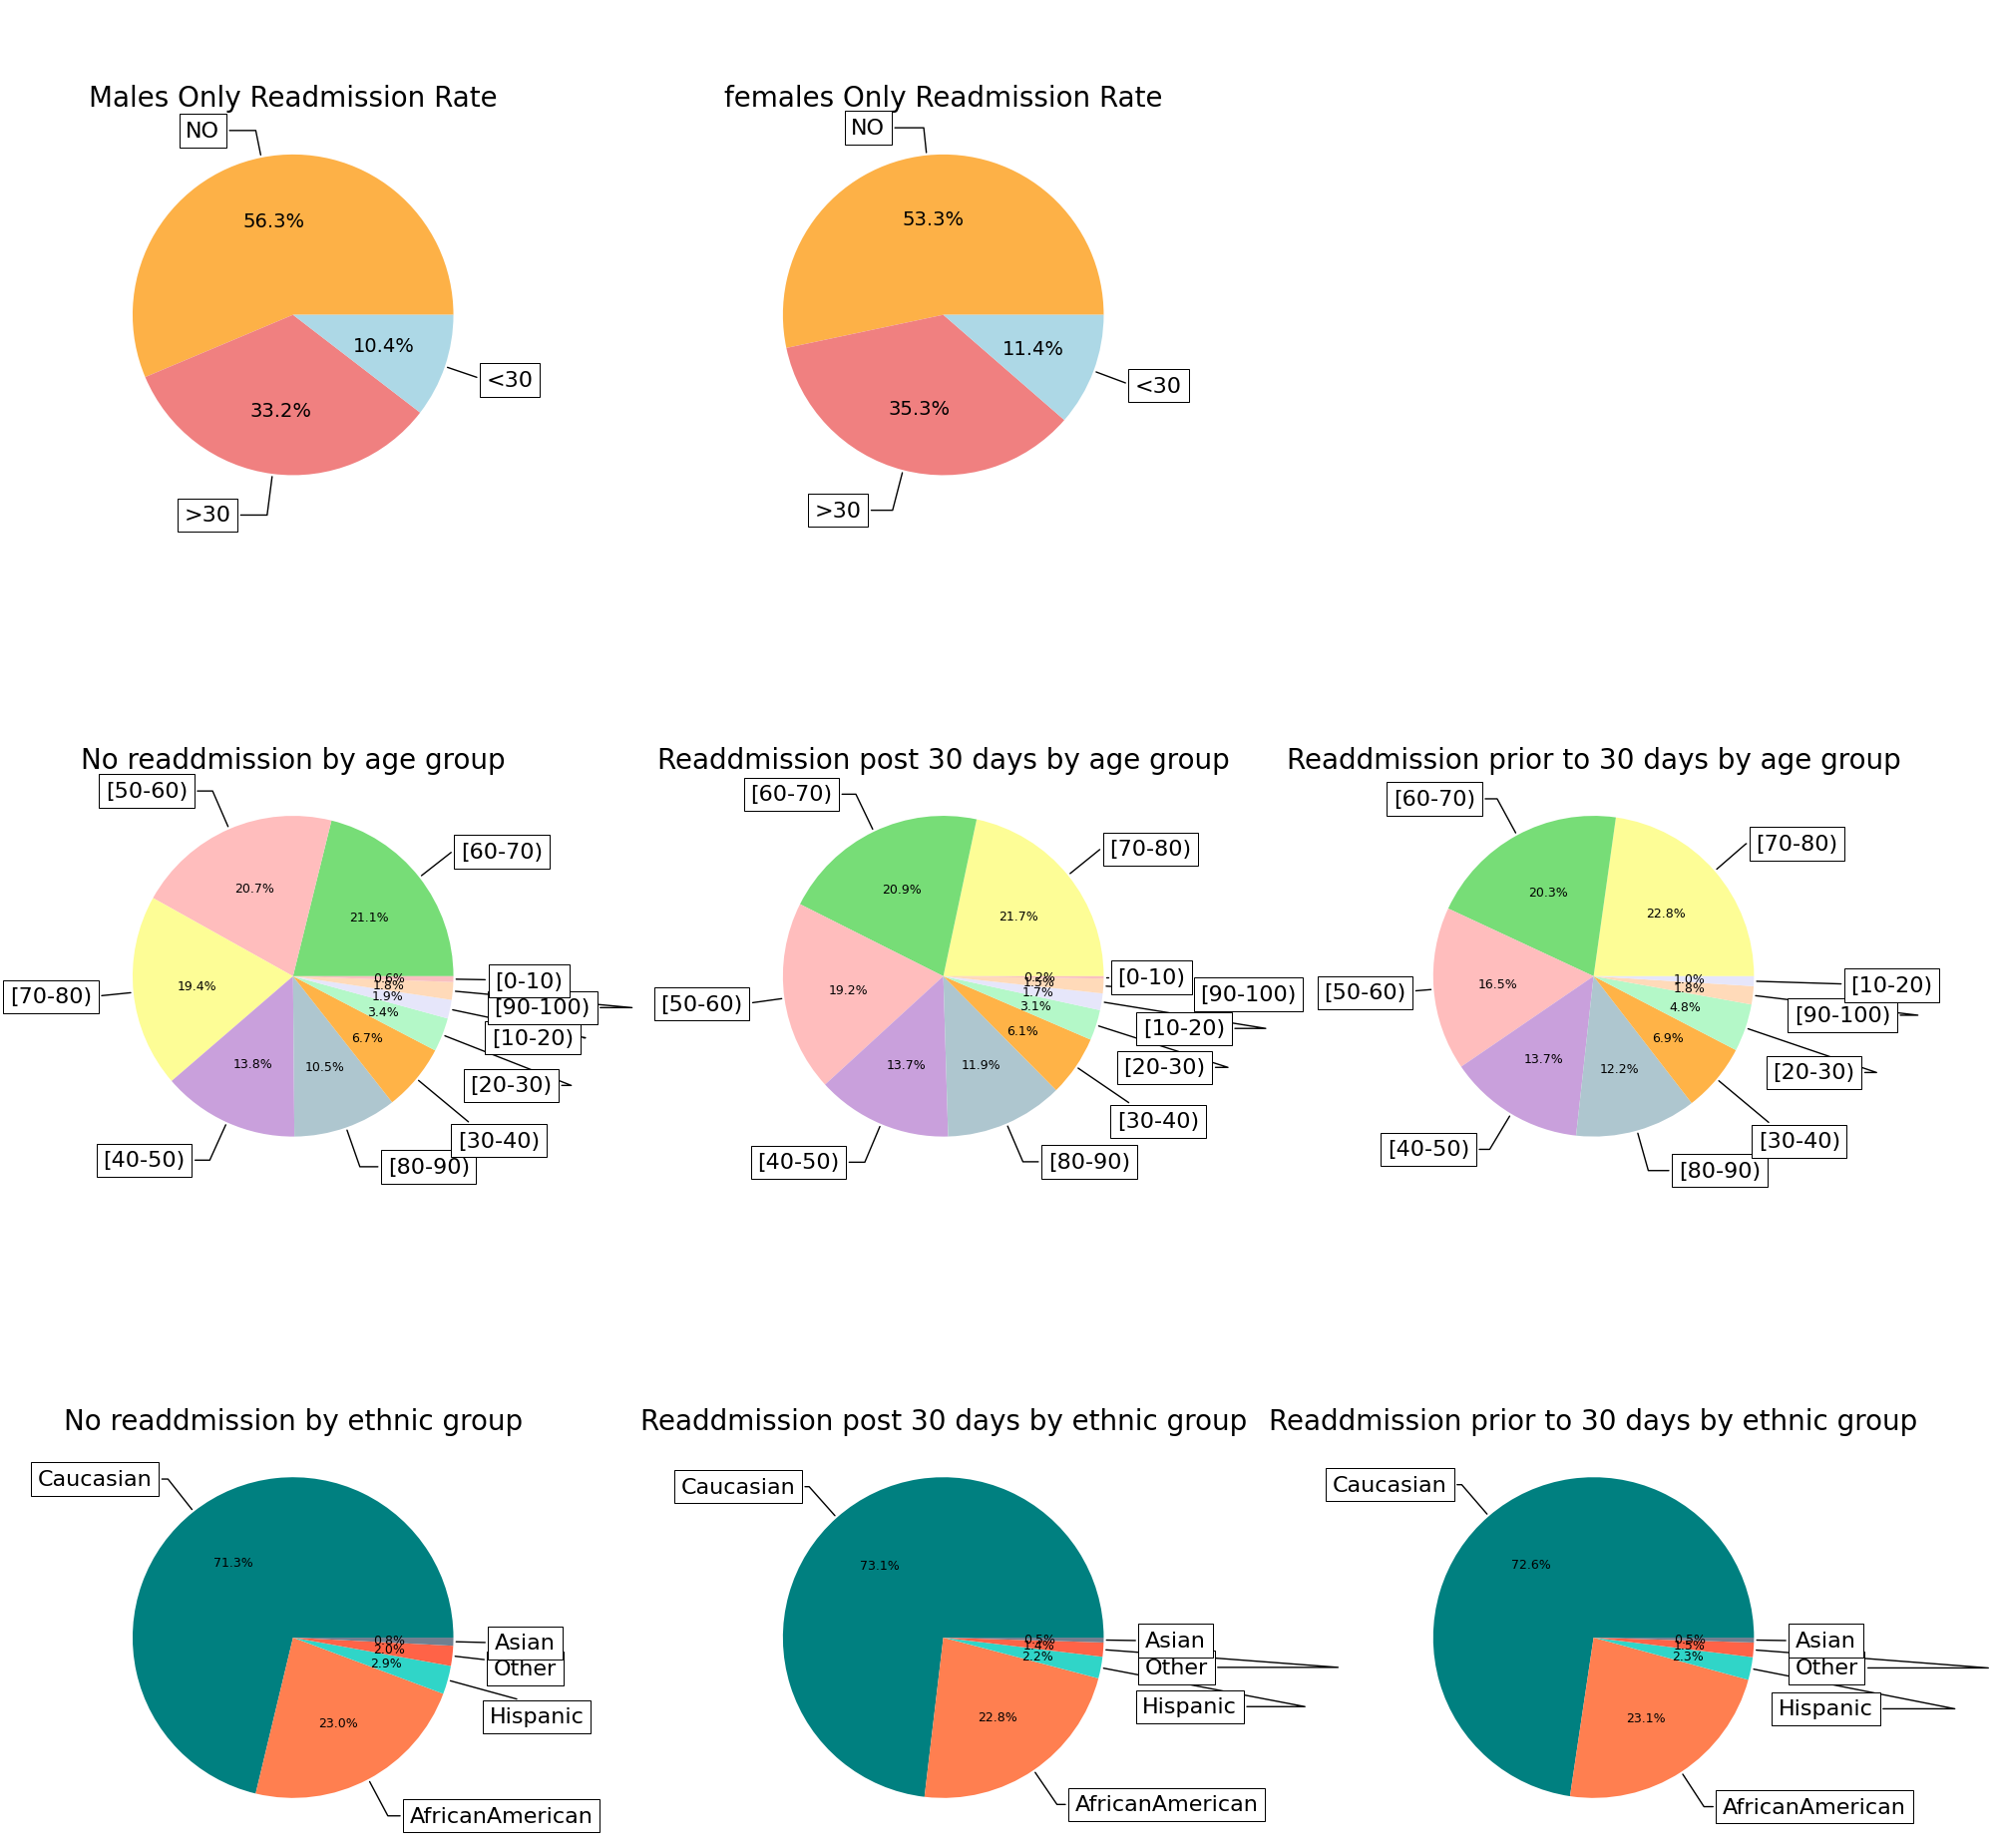

In [12]:
# plot pie charts for labels across different stratifications 
eda_plots = plotsEDA()

# run a for loop to plot all possible pie charts we had in mind #

# set lyaout of plots #
n_charts = 8

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
for i in range(n_charts):
    # Prepare your data for each subplot
    # for Gender pie charts
    if i < 2:
        filtered_data = train_df[train_df['gender'] == ('Male' if i % 2 == 0 else 'Female')]
        rate = filtered_data['readmitted'].value_counts()

        # set title
        if i % 2 == 0:
            title = 'Males Only Readmission Rate'
        else:
            title = 'females Only Readmission Rate'
               
        eda_plots.plot_pie_chart(data=rate, ax=axs[i], title=title,
                                 title_font_size=20, annotation_font_size=16, pie_font_size=14,
                                 annotation_offsets=[(0.3,0.2)])
    elif i < 5:
        if i % 3 == 0:
            filtered_data = train_df[train_df['readmitted'].isin(['>30'])]
            rate = filtered_data['age'].value_counts()
            title = 'Readdmission post 30 days by age group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#fdfd96','#77dd77','#ffbdbd','#c9a0dc','#aec6cf','#ffb347',
                                            '#b4f8c8','#e6e6fa','#ffdab9','#f9c0c0'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.7),
                                                        (0.2,1),(0.3,1.2),(0.7,1),(0.1,0),(0.3,0)])
        elif i < 3:
            filtered_data = train_df[train_df['readmitted'].isin(['NO'])]
            rate = filtered_data['age'].value_counts()
            title = 'No readdmission by age group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#77dd77','#ffbdbd','#fdfd96','#c9a0dc','#aec6cf','#ffb347',
                                            '#b4f8c8','#e6e6fa','#ffdab9','#f9c0c0'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.7),
                                                        (0.2,1),(0.3,1),(0.3,1.3),(0.3,0.7),(0.3,0)])
        else:
            filtered_data = train_df[train_df['readmitted'].isin(['<30'])]
            rate = filtered_data['age'].value_counts()
            title = 'Readdmission prior to 30 days by age group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#fdfd96','#77dd77','#ffbdbd','#c9a0dc','#aec6cf','#ffb347',
                                            '#b4f8c8','#ffdab9','#e6e6fa',],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.2,0.3),(0.3,0.3),(0.3,0.3),(0.3,0.7),
                                                        (0.2,1),(0.3,1.2),(0.7,1),(0.1,0),(0.3,0)])
    else:
        if i % 3 == 0:
            filtered_data = train_df[train_df['readmitted'].isin(['>30'])]
            rate = filtered_data['race'].value_counts()
            title = 'Readdmission post 30 days by ethnic group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#008080','#FF7F50','#30D5C8','#FF6347','#708090'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,1.5),(0.3,1.7),(0.3,0.3)])
        elif i < 6:
            filtered_data = train_df[train_df['readmitted'].isin(['NO'])]
            rate = filtered_data['race'].value_counts()
            title = 'No readdmission by ethnic group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#008080','#FF7F50','#30D5C8','#FF6347','#708090'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.3,1),(0.3,0.8),(0.3,0.3)])
        else:
            filtered_data = train_df[train_df['readmitted'].isin(['<30'])]
            rate = filtered_data['race'].value_counts()
            title = 'Readdmission prior to 30 days by ethnic group'
            eda_plots.plot_pie_chart(data=rate, ax=axs[i+1], title=title,
                                    title_font_size=20, annotation_font_size=16, pie_font_size=9,
                                    colors=['#008080','#FF7F50','#30D5C8','#FF6347','#708090'],
                                    annotation_offsets=[(0.3,0.3),(0.3,0.3),(0.2,1.5),(0.3,1.7),(0.3,0.3)])

axs[2].axis('off') # remove emplt graph

plt.tight_layout()  # Adjust the layout so everything fits without overlapping
plt.show()

#eda_plots.plot_pie_chart(data=males_only_rate, title='Males Only Readmission Rate', 
                         #title_font_size=20, annotation_font_size=16, pie_font_size=16)

d:\yahel\phd\courses\ML in biology research\final_project\Diabetic_readmission_essentials.py:169: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x, y=y, palette=colors, showmeans=showmeans, meanprops=meanprops, ax=ax)
d:\yahel\phd\courses\ML in biology research\final_project\final_project_ml\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\yahel\phd\courses\ML in biology research\final_project\final_project_ml\lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_

(0.0, 1.0, 0.0, 1.0)

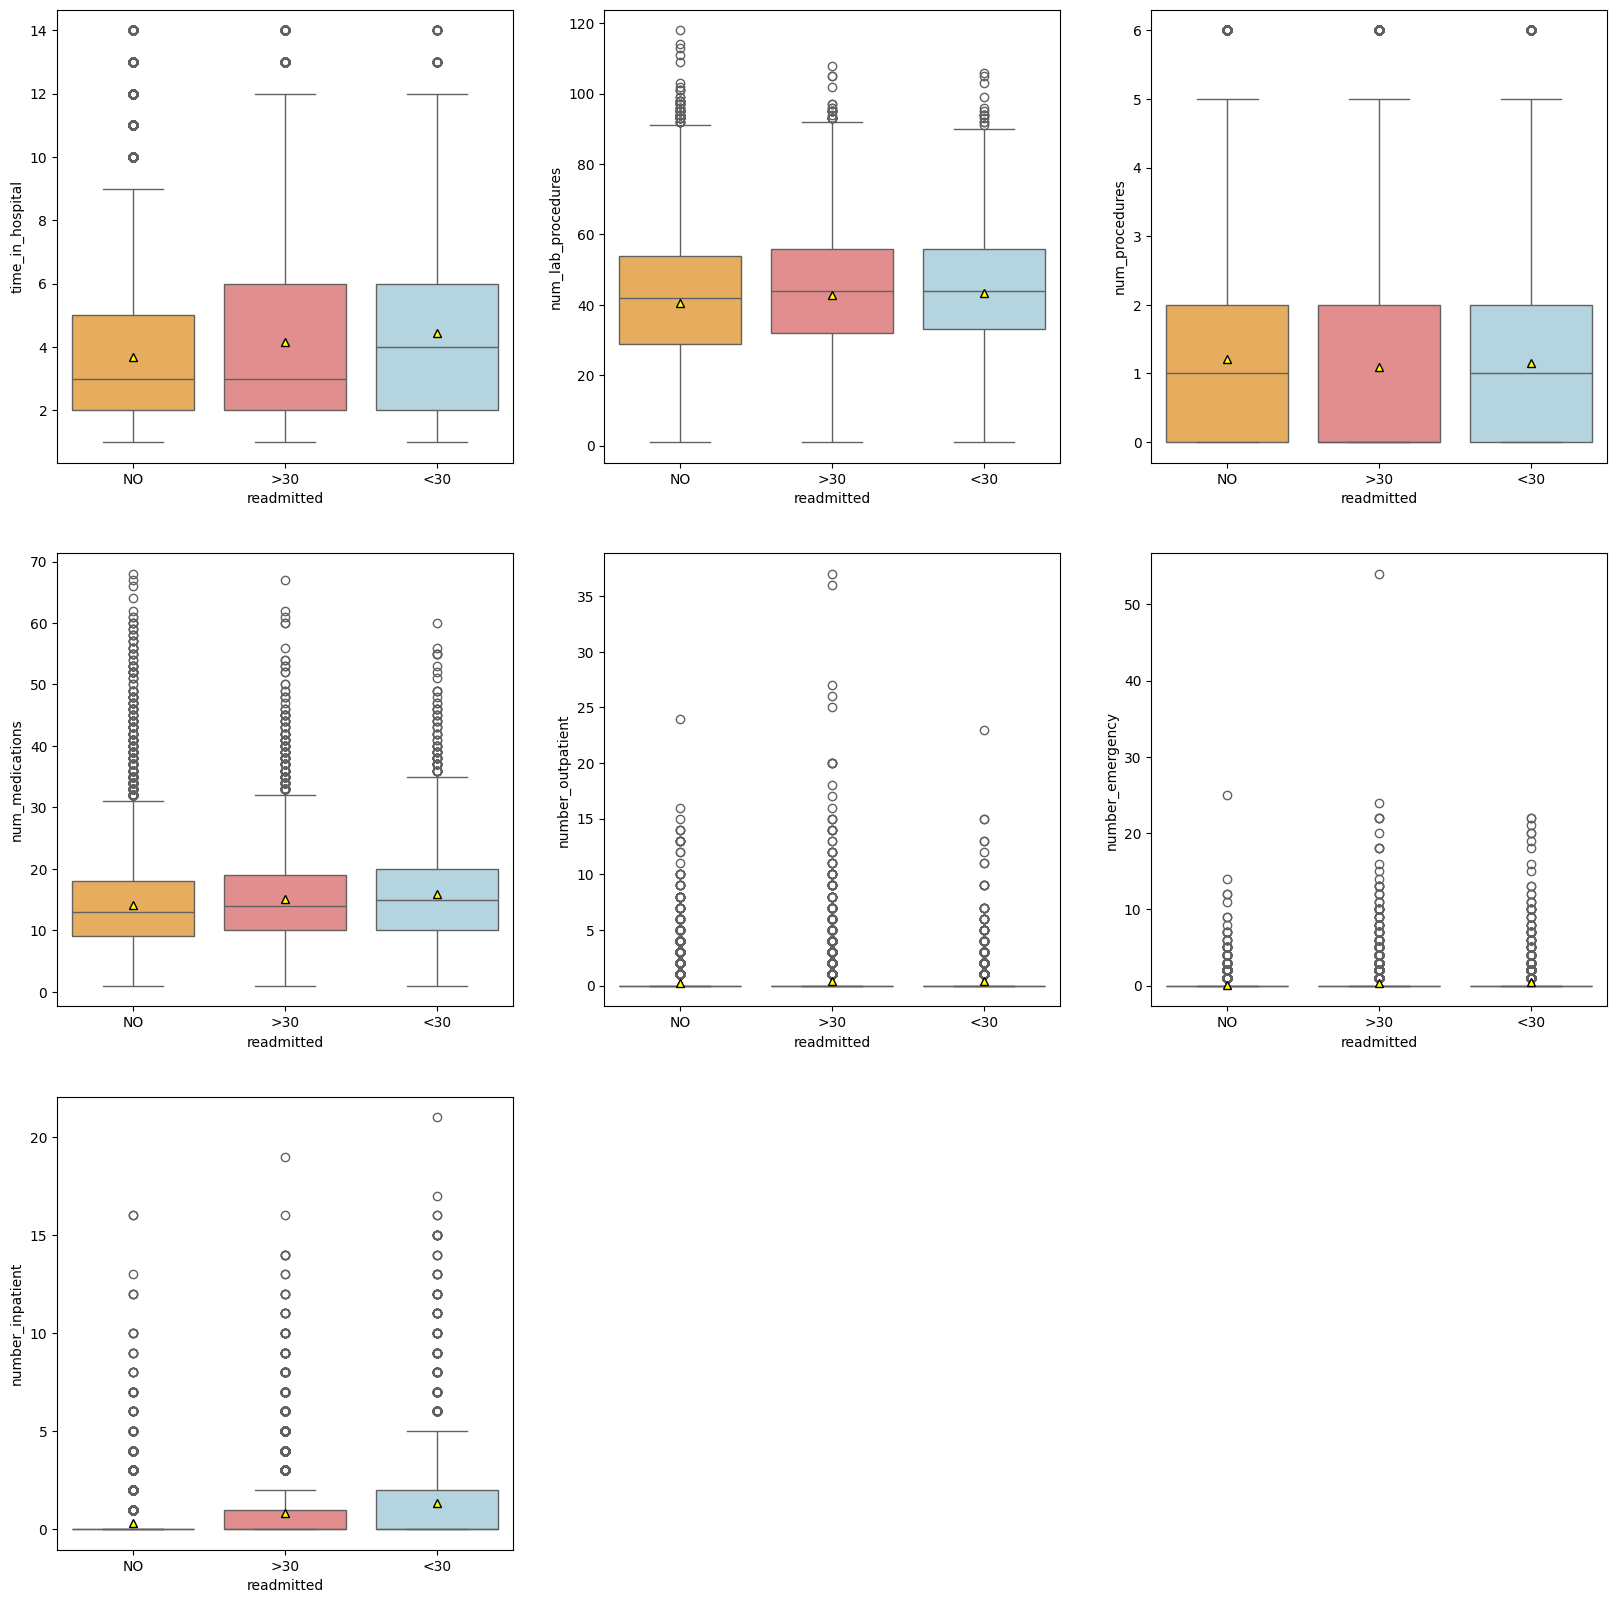

In [13]:
train_df.columns
num_features = ['time_in_hospital','num_lab_procedures','num_procedures',
                'num_medications','number_outpatient','number_emergency','number_inpatient']

# run a for loop to plot all possible numerical values compared to label #

# set lyaout of plots #
n_charts = 7

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
for i,num in enumerate(num_features):
    eda_plots.plot_boxplot(train_df,x='readmitted', y=num,ax=axs[i])

axs[8].axis('off') ; axs[7].axis('off') # remove empty plots

In [14]:
# add new columns for diagnosis categories 

train_df['diag_1_cat'] = train_df['diag_1'].apply(categorize_dia)
train_df['diag_2_cat'] = train_df['diag_2'].apply(categorize_dia)
train_df['diag_3_cat'] = train_df['diag_3'].apply(categorize_dia)

# loop over different diagnosis save diabetes and append thier labels

disease_list = {'Other','Circulatory','Respiratory','Digestive','Injury',
                'Musculoskeletal','Genitourinary','Neoplasms'}
stacked_bx_df = None
n_patients_per_disease = []
for key in disease_list:
    disease_patient_filter = train_df[['diag_1_cat','diag_2_cat','diag_3_cat']].apply(lambda x: x.isin([key]).sum(), axis = 1) > 0
    
    # get label for pateint who was diagnosed at least once with the disease
    disease_subset = train_df['readmitted'][disease_patient_filter].reset_index(drop = False)['readmitted']
    
    # keep the total number pf pateints diagnosed 
    n_patients_per_disease.append(len(disease_subset))
    
    # normalize to number of disease diagnosis to get ratio of labels within each disease
    disease_subset = disease_subset.value_counts()/ len(disease_subset)
        
    if stacked_bx_df is None:
        stacked_bx_df = pd.DataFrame({key : disease_subset})
    else:
        stacked_bx_df = stacked_bx_df.merge(pd.DataFrame({key : disease_subset}),
                                            left_index=True,right_index=True)
         
stacked_bx_df

C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\1178890869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['diag_1_cat'] = train_df['diag_1'].apply(categorize_dia)
C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\1178890869.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['diag_2_cat'] = train_df['diag_2'].apply(categorize_dia)
C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\1178890869.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,Neoplasms,Respiratory,Digestive,Injury,Circulatory,Other,Musculoskeletal,Genitourinary
readmitted,,,,,,,,
NO,0.630975,0.531564,0.535324,0.552044,0.540632,0.541321,0.608052,0.507669
>30,0.259082,0.372355,0.348174,0.318801,0.349622,0.343366,0.298139,0.376994
<30,0.109943,0.096080,0.116502,0.129155,0.109746,0.115313,0.093809,0.115337


Text(0.5, 1.0, 'Readmission rate per label across diagnoses')

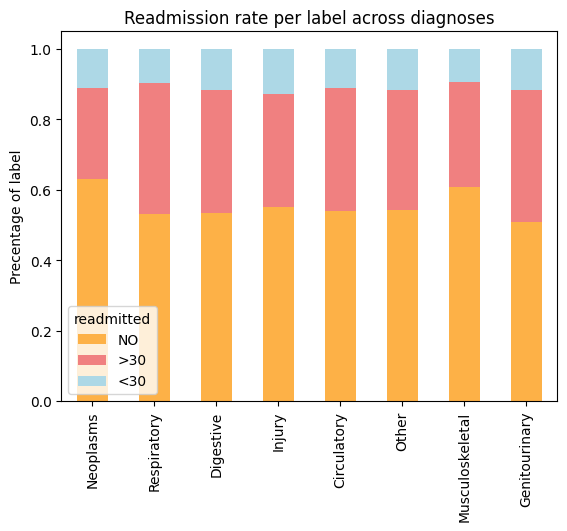

In [15]:
stacked_bx_df.T.plot(kind='bar', stacked=True,
                     color=['#fdb147', 'lightcoral', 'lightblue'])

plt.ylabel('Precentage of label')
 
# title of plot
plt.title('Readmission rate per label across diagnoses')

# EDA part ends here!!!

In [16]:
mapping_path = 'D:\yahel\phd\courses\ML in biology research\\final_project\data\IDS_mapping.csv'

#Read readmission mapping file
pd.read_csv(mapping_path,header=None)

,0,1
0,admission_type_id,description
1,1,Emergency
2,2,Urgent
3,3,Elective
4,4,Newborn
...,...,...
63,22,Transfer from hospital inpt/same fac reslt in...
64,23,Born inside this hospital
65,24,Born outside this hospital
66,25,Transfer from Ambulatory Surgery Center


In [17]:
mapping_path = 'D:\yahel\phd\courses\ML in biology research\\final_project\data\IDS_mapping.csv'

#Read readmission mapping file
mapping_df = pd.read_csv(mapping_path,header=None)
#print(mapping_df.head())
original_shape_num_rows = mapping_df.shape[0]

#Remove empty rows
mapping_df = mapping_df.dropna(how='all', inplace=False) #removes 2 gap rows

#Fill empty desctioption cells with NaNs they were previously NULL
mapping_df = mapping_df.fillna(value='NaN', inplace=False)
print("Does the new mapping_df has less rows than the original? ",mapping_df.shape[0]< original_shape_num_rows) #QC

#Reset indices
mapping_df = mapping_df.reset_index(drop=True)

Does the new mapping_df has less rows than the original?  True


In [18]:
### Rearrange IDS_mapping table by storing each categorical column with its description in a df inside a dictionary
#Find rows containing the string "id" in any column
id_rows = mapping_df[mapping_df.apply(lambda row: row.astype(str).str.contains('_id', case=False)).any(axis=1)]
#print(id_rows)
id_names = list(id_rows[0])
#print(mapping_df.iloc[9])

# Extract the index of the id rows
id_rows_indices = list(id_rows.index)

#print(id_rows_indices)

# Create a dictionary with the 3 mapping dataframes
mapping_dictionary = {}

#Iterate over id_names to create subsets of mapping_df
for id_i in range(0,len(id_rows_indices)-1):
    start_index = id_rows_indices[id_i]
    end_index = id_rows_indices[id_i+1]
    #print(start_index,end_index)
    
    # Extract the subset DataFrame
    current_id_df = mapping_df.iloc[start_index:end_index]  #+1 Include end_index
    #print(current_id_df)
                 
    #Assign the values of the first row as column names
    current_id_df.columns = current_id_df.iloc[0]
    #print(current_id_df.columns)

    # Drop the first row after using it as column names
    current_id_df = current_id_df[1:].reset_index(drop=True)

    # Assign the subset DataFrame to the corresponding key in the dictionary
    mapping_dictionary[id_names[id_i]] = current_id_df
    
# Add the last subset DataFrame explicitly
last_start_index = id_rows_indices[-1]
last_id_df = mapping_df.iloc[last_start_index:]
last_id_df.columns = last_id_df.iloc[0]
last_id_df = last_id_df[1:].reset_index(drop=True)
mapping_dictionary[id_names[-1]] = last_id_df

print("The dictionary contains",len(mapping_dictionary.items()), "items")

#View dictionary dfs
for key, df in mapping_dictionary.items():
    print(f"Head of DataFrame {key}:")
    print(df.head())
    print()

The dictionary contains 3 items
Head of DataFrame admission_type_id:
0 admission_type_id    description
0                 1      Emergency
1                 2         Urgent
2                 3       Elective
3                 4        Newborn
4                 5  Not Available

Head of DataFrame discharge_disposition_id:
9 discharge_disposition_id                                        description
0                        1                                 Discharged to home
1                        2  Discharged/transferred to another short term h...
2                        3                      Discharged/transferred to SNF
3                        4                      Discharged/transferred to ICF
4                        5  Discharged/transferred to another type of inpa...

Head of DataFrame admission_source_id:
40 admission_source_id                                      description
0                    1                               Physician Referral
1                    2  

In [19]:

### Replace the values in the training df with the values in the dictionary
#Avoid overight of the trining df (optional)
training_df_new = train_df.copy()

training_df_new[id_names] = training_df_new[id_names].astype('str')

# Check that the columns in the DataFrame appear in the list
matching_columns = [col for col in training_df_new.columns if col in id_names]
matching_columns == id_names #QC

# Iterate over rows in training_df_new
for id_i in id_names:
#Extract the df in mapping_dictionary for the the id_column in training_df_new
    current_dict_df = mapping_dictionary[id_i]
    #Merge the discionary columns with the training_df_new
    training_df_new = training_df_new.merge(current_dict_df,on = id_i, how ='left',suffixes=['_left','_right'])

#Rename the new columns - last 3 columns in the df
new_column_names = [element[:-3] + "_descriptor" if element.endswith("_id") else element for element in id_names]

# Create a mapping dictionary for renaming
rename_dict = dict(zip(training_df_new.columns[-3:], new_column_names))
training_df_new = training_df_new.rename(columns=rename_dict)
print(training_df_new.iloc[:,-3:])

# removes ages 0-10 as there are little of them and no readmision rate
training_df_new = training_df_new[~training_df_new['age'].isin(['[0-10)'])]

# removes values with Trauma Center and Newborn in the admission as they have only few (5) records
training_df_new = training_df_new[~training_df_new['admission_type_descriptor'].isin(['Trauma Center','Newborn'])]

      admission_type_descriptor  \
0                           NaN   
1                     Emergency   
2                     Emergency   
3                     Emergency   
4                     Emergency   
...                         ...   
30415                 Emergency   
30416                  Elective   
30417                  Elective   
30418                 Emergency   
30419                 Emergency   

                        discharge_disposition_descriptor  \
0                                             Not Mapped   
1                                     Discharged to home   
2                                     Discharged to home   
3                                     Discharged to home   
4                                     Discharged to home   
...                                                  ...   
30415                      Discharged/transferred to ICF   
30416  Discharged/transferred to home with home healt...   
30417                                 D

In [20]:
class ColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_remove):
        self.columns_to_remove = columns_to_remove
        
    def fit(self, X, y=None):
        # just return self
        return self
    
    def transform(self, X):
        # Ensure X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        
        # Remove the specified columns and return the modified DataFrame
        return X.drop(columns=self.columns_to_remove, errors='ignore')
    
    
unecessery_columns = ['encounter_id', 'patient_nbr','weight','payer_code','diag_1','diag_2','diag_3',
                       'chlorpropamide','tolbutamide','tolbutamide','repaglinide','acarbose','miglitol','troglitazone','acetohexamide','nateglinide',
                       'tolazamide','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'admission_type_id','discharge_disposition_id','admission_source_id','max_glu_serum','A1Cresult','admission_source_descriptor']

remover = ColumnRemover(columns_to_remove=unecessery_columns)
omitted_df = remover.transform(training_df_new)




In [21]:
# a class for numerical scaling
# optional log2 for chosen features by name
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, log_column='num_medications'):
        
        """_summary_
            columns: list of column names for Min-Max scaling
            log_column: specific column name to apply log2 transformation before Min-Max scaling
        """
        self.columns = columns
        self.log_column = log_column
        self.scalers = {}  # To store individual scalers per column
        
    def fit(self, X, y=None):
        # Fit scaler to each specified column individually
        for col in self.columns:
            scaler = MinMaxScaler()
            if col == self.log_column:
                # Log-transform then fit scaler
                self.scalers[col] = scaler.fit(np.log2(X[[col]] + 1))
            else:
                # Fit scaler directly
                self.scalers[col] = scaler.fit(X[[col]])
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if col == self.log_column:
                # Log-transform then scale
                X_transformed[col] = self.scalers[col].transform(np.log2(X_transformed[[col]] + 1))
            else:
                # Scale directly
                X_transformed[col] = self.scalers[col].transform(X_transformed[[col]])
        return X_transformed




to_scale_cols = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
                 'number_outpatient','number_emergency','number_inpatient','number_diagnoses']

num_processing = NumericalTransformer(columns=to_scale_cols)


omitted_df = num_processing.fit_transform(omitted_df)
omitted_df
# set lyaout of plots #
# n_charts = 8

# fig, axs = plt.subplots(2, 4, figsize=(15, 15))
# axs = axs.flatten()
# for i,num in enumerate(num_cols):
#     processed_data.plot.hist(column=[num],ax=axs[i],bins = 50)

,race,gender,age,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,rosiglitazone,insulin,change,diabetesMed,readmitted,diag_1_cat,diag_2_cat,diag_3_cat,admission_type_descriptor,discharge_disposition_descriptor
1,Caucasian,Female,[10-20),0.153846,NaN,0.495726,0.000000,0.635786,0.000000,0.000000,...,No,Up,Ch,Yes,>30,Other,Diabetes,Other,Emergency,Discharged to home
2,AfricanAmerican,Female,[20-30),0.076923,NaN,0.085470,0.833333,0.549543,0.054054,0.000000,...,No,No,No,Yes,NO,Other,Diabetes,Other,Emergency,Discharged to home
3,Caucasian,Male,[30-40),0.076923,NaN,0.367521,0.166667,0.604375,0.000000,0.000000,...,No,Up,Ch,Yes,NO,Other,Diabetes,Circulatory,Emergency,Discharged to home
4,Caucasian,Male,[40-50),0.000000,NaN,0.427350,0.000000,0.424766,0.000000,0.000000,...,No,Steady,Ch,Yes,NO,Neoplasms,Neoplasms,Diabetes,Emergency,Discharged to home
5,Caucasian,Male,[50-60),0.153846,NaN,0.256410,1.000000,0.604375,0.000000,0.000000,...,No,Steady,No,Yes,>30,Circulatory,Circulatory,Diabetes,Urgent,Discharged to home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30415,Caucasian,Female,[40-50),1.000000,NaN,0.581197,0.000000,0.604375,0.000000,0.000000,...,No,Down,Ch,Yes,>30,Other,Other,Diabetes,Emergency,Discharged/transferred to ICF
30416,Caucasian,Female,[70-80),0.153846,Orthopedics,0.222222,0.166667,0.764779,0.000000,0.018519,...,No,Steady,Ch,Yes,NO,Musculoskeletal,Circulatory,Diabetes,Elective,Discharged/transferred to home with home healt...
30417,Caucasian,Female,[80-90),0.153846,NaN,0.256410,0.333333,0.713289,0.000000,0.000000,...,No,Down,Ch,Yes,<30,Digestive,Digestive,Diabetes,Elective,Discharged to home
30418,Other,Male,[40-50),0.923077,NaN,0.427350,0.333333,0.549543,0.000000,0.000000,...,No,Down,Ch,Yes,NO,Diabetes,Musculoskeletal,Musculoskeletal,Emergency,Discharged to home


In [22]:
class CustomeLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,label_column:str = None):
        """class to encode the label and split the dataframe to y and X
            Args:
            label_column (str): the column name of the target column
            X (Dataframe): the dataframe to be split and encoded
        """

        self.label_column = label_column
        self.label_encoder = None
         
        if self.label_column is None:
            raise ValueError("Label column name must be specified.")
        
    def fit(self,X, y=None):
        
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(X[self.label_column])
        return self
    
    def transform(self, X):
        
        X_transformed = X.drop(columns=[self.label_column])
        y_transformed = pd.Series(self.label_encoder.transform(X[self.label_column]), name=self.label_column)
        
        return X_transformed, y_transformed
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

X , y= CustomeLabelEncoder(label_column='readmitted').fit_transform(omitted_df)

In [23]:
# SMOTENC transformer for use in an sklearn pipeline.
class SMOTENC_NS(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features,
                 sampling_strategy = 'auto', k_neighbors=5, seed =42):
        """
        Parameters:
        categorical_features: array of ints corresponding to the indices specifying the categorical features
        - sampling_strategy: Determine oversampling ratios, for multiclass dict is preferable.
            defualts to "auto" and will oversample all classes to the majority class
        - k_neighbors: Number of nearest neighbors used for the algorithm.
        - seed: Random pseudoseed for KNN
        """
        self.categorical_features = categorical_features
        self.k_neighbors = k_neighbors
        self.seed = seed
        self.sampling_strategy = sampling_strategy
    
    def fit_resample(self, X, y):
        """
        Fits the SMOTENC resampler to the data and resamples it.
        
        Parameters:
        - X: Features matrix
        - y: Target vector
        
        Returns:
        - X_resampled: The resampled features matrix
        - y_resampled: The resampled target vector
        """
        
        
        if self.categorical_features is None:
            raise ValueError("Categorical feature indexes are not specified.")
        
        # Encode your target variable if it's categorical
        
        # Initialize SMOTENC with user-specified parameters
        self.smotenc = SMOTENC(categorical_features=self.categorical_features, 
                               k_neighbors=self.k_neighbors, 
                               random_state=self.seed,
                               sampling_strategy = self.sampling_strategy)
        
        # Fit SMOTENC and resample the data
        X_resampled, y_resampled = self.smotenc.fit_resample(X, y)
        #returned_df = X_resampled
        #returned_df['label'] = label_encoder.inverse_transform(y_resampled) # get original labels value back
        #pd.DataFrame(returned_df)
        return X_resampled, y_resampled
    

categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['category', 'object']).columns]

#sampling_strategy = {0: 12000, 1: 12000}
smote_os = SMOTENC_NS(categorical_features= categorical_features_indices,
                       k_neighbors= 5, seed=42)


X_resampled, y_resampled = smote_os.fit_resample(X,y)

In [24]:
nan_columns = omitted_df.groupby('readmitted').apply(lambda x: x.isna().sum())
nan_columns[['race','medical_specialty','diag_1_cat','diag_2_cat','diag_3_cat']]

C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\1902499075.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_columns = omitted_df.groupby('readmitted').apply(lambda x: x.isna().sum())


,race,medical_specialty,diag_1_cat,diag_2_cat,diag_3_cat
readmitted,,,,,
<30,56,1617,2,15,64
>30,137,4957,2,31,250
NO,528,7106,1,119,638


In [25]:
omitted_df['readmitted'].value_counts()

readmitted
NO     16542
>30    10421
<30     3331
Name: count, dtype: int64

In [26]:
class CustomOHEncoder(BaseEstimator, TransformerMixin):
    
    """_summary_ 
    OHE categorical features in different manners
    OHE_regular_cols - columns to reguular OHE with sklearn class
    OHE_4_to_2_cols - columns to change 4 values to 2 values
                      all medication were reduced to 1 - changed dose / 0 - stable/NaN
    change_col - column to chnage after chage in OHE_4_to_2_cols
                 specifically for "Change" column to see if there was a change in medication based
                 based on a "Yes" and a lack of change of dosage in other medications
    diag_cols - coulmns to be expanded specifically diagnoses columns where each pateint
                had more than 2 diagnoses so expand to column per disease and drops diabetes
    """
    def __init__(self, OHE_regular_cols=[], OHE_4_to_2_cols=[], change_col=None, diag_cols=[]):
        self.OHE_regular_cols = OHE_regular_cols
        self.OHE_4_to_2_cols = OHE_4_to_2_cols
        self.change_col = change_col
        self.diag_cols = diag_cols
        self.ohe = OneHotEncoder(drop='if_binary')
        self.unique_diagnoses = None

    def fit(self, X, y=None):
        # Fit the regular OHE encoder
        if self.OHE_regular_cols:
            self.ohe.fit(X[self.OHE_regular_cols])
        
        # Prepare unique diagnoses for diagnosis encoding
        if self.diag_cols:
            melted_disease = pd.melt(X[self.diag_cols])
            self.unique_diagnoses = melted_disease['value'].unique()
        
        return self

    def transform(self, X):
        result = X.copy()
        
        # Apply regular OHE
        if self.OHE_regular_cols:
            transformed = self.ohe.transform(result[self.OHE_regular_cols]).toarray()
            result = result.drop(columns=self.OHE_regular_cols)
            result = result.join(pd.DataFrame(transformed, columns=self.ohe.get_feature_names_out(), index=result.index))
        
        # Apply 4-to-2 encoding - for medication
        if self.OHE_4_to_2_cols:
            result[self.OHE_4_to_2_cols] = result[self.OHE_4_to_2_cols].replace({'No': 0, 'Steady': 0, 'Up': 1, 'Down': 1})
        
        # Apply "change" transformation 
        #based on medication swap and not dosage change
        
        if self.change_col and self.OHE_4_to_2_cols:
            # checks if dosage was not chamges among medication exisitng in dataset
            dosage_changed_bool = result[self.OHE_4_to_2_cols].apply(lambda x: sum(x > 0) == 0, axis=1)
            
            # iterate to over all records ,mark 1 where doasge was not changed but medication was
            new_change = [(1 if i and ch == 'Ch' else 0) for i, ch in zip(dosage_changed_bool, result[self.change_col])]
            result[self.change_col] = new_change
        
        # Apply disease diagnosis encoding
        if self.diag_cols and self.unique_diagnoses is not None:
            # prepare a zero matrix to count for dieases per patient
            ohe_diagnosis = pd.DataFrame(np.zeros((result.shape[0], len(self.unique_diagnoses))),
                                         columns=self.unique_diagnoses, index=result.index)
            #get disease diagnosis per record 
            record_disease = result[self.diag_cols].apply(lambda x: x.value_counts().index.values, axis=1)
            
            # iterate over pateint diagnosis and add one to ohe_diagnosis in the relevant place
            for row, diag in enumerate(record_disease):
                for dis in diag:
                    if dis in ohe_diagnosis.columns:
                        ohe_diagnosis.loc[row, dis] = 1
            
            # drop Diabetes since they all have it
            ohe_diagnosis.drop(['Diabetes'], axis=1, inplace=True, errors='ignore')
            ohe_diagnosis = ohe_diagnosis.iloc[:, :-1]  # Drop last column for None diagnosis
            
            # remove input columns
            result = result.drop(columns=self.diag_cols)
            # add the untouched columns
            result = result.join(ohe_diagnosis)
        
        return result
  
    
OHE_regular_cols = ['race','gender','age','medical_specialty','insulin','diabetesMed','admission_type_descriptor','discharge_disposition_descriptor']
OHE_4_to_2_cols = ['metformin','glimepiride', 'glipizide', 'glyburide', 'pioglitazone','rosiglitazone']
diagnoses_cols = ['diag_1_cat','diag_2_cat','diag_3_cat']

ohe = CustomOHEncoder(OHE_regular_cols= OHE_regular_cols, OHE_4_to_2_cols=OHE_4_to_2_cols,
                       change_col='change', diag_cols=diagnoses_cols)


X_ohe = ohe.fit_transform(X_resampled)
X_ohe.columns = X_ohe.columns.str.replace('[','')

C:\Users\yahelc\AppData\Local\Temp\ipykernel_27876\2035611965.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result[self.OHE_4_to_2_cols] = result[self.OHE_4_to_2_cols].replace({'No': 0, 'Steady': 0, 'Up': 1, 'Down': 1})


In [27]:
pd.set_option('display.max_columns', None)
display(X_ohe)
pd.set_option('display.max_columns', 20)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,change,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_nan,gender_Male,age_10-20),age_20-30),age_30-40),age_40-50),age_50-60),age_60-70),age_70-80),age_80-90),age_90-100),medical_specialty_AllergyandImmunology,medical_specialty_Anesthesiology,medical_specialty_Anesthesiology-Pediatric,medical_specialty_Cardiology,medical_specialty_Cardiology-Pediatric,medical_specialty_DCPTEAM,medical_specialty_Dentistry,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Endocrinology-Metabolism,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_Obstetrics,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Ophthalmology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_OutreachServices,medical_specialty_Pathology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-AllergyandImmunology,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-EmergencyMedicine,medical_specialty_Pediatrics-Endocrinology,medical_specialty_Pediatrics-Hematology-Oncology,medical_specialty_Pediatrics-InfectiousDiseases,medical_specialty_Pediatrics-Neurology,medical_specialty_Pediatrics-Pulmonology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Rheumatology,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,medical_specialty_nan,insulin_Down,insulin_No,insulin_Steady,insulin_Up,diabetesMed_Yes,admission_type_descriptor_Elective,admission_type_descriptor_Emergency,admission_type_descriptor_NaN,admission_type_descriptor_Not Available,admission_type_descriptor_Not Mapped,admission_type_descriptor_Urgent,discharge_disposition_descriptor_Admitted as an inpatient to this hospital,discharge_disposition_descriptor_Discharged to home,discharge_disposition_descriptor_Discharged/transferred to ICF,discharge_disposition_descriptor_Discharged/transferred to SNF,discharge_disposition_descriptor_Discharged/transferred to a federal health care facility.,discharge_disposition_descriptor_Discharged/transferred to a long term care hospital.,discharge_disposition_descriptor_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,discharge_disposition_descriptor_Discharged/transferred to another rehab fac including rehab units of a hospital .,discharge_disposition_descriptor_Discharged/transferred to another short term hospital,discharge_disposition_descriptor_Discharged/transferred to another type of inpatient care institution,discharge_disposition_descriptor_Discharged/transferred to home under care of Home IV provider,discharge_disposition_descriptor_Discharged/transferred to home with home hea

## run models on oversampled cohort to choose best option 

In [30]:
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Define a custom scoring function
def custom_avg_precision_score(y_true, y_pred):
    return average_precision_score(y_true, y_pred, average='macro')

# Create scorer
macro_avg_precision_scorer = make_scorer(custom_avg_precision_score, needs_proba=True)

def defaults_model_results(X:pd.DataFrame, y:pd.Series, folds:int, score): 
    """_summary_

    Args:
        X (pd.DataFrame): features to predict y
        y (pd.Series): prediction label
        folds (int): nu,ber of folds to test
        score (string/scorer object): is string than must be of one exisiting in sklearn. if not than must be a scorer that works with sklearn 
    """
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    #logistic
    MLR = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000))
    mlr_scores = cross_val_score(MLR, X, y, cv=cv, scoring=score, verbose=3)
    
    # XGBOOST
    xgb = OneVsRestClassifier(XGBClassifier(use_label_encoder=False,))
    xgb_scores = cross_val_score(xgb, X, y, cv=cv, scoring=score, verbose=3)
    
    # random forest
    RFclass = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 7))
    rf_score =  cross_val_score(RFclass, X, y, cv=cv, scoring=score, verbose=3)
    
    mean_score = [mlr_scores.mean(),xgb_scores.mean(),rf_score.mean()]
    models = ['Logistic regression','XGBoost','RandomForest']
    
    return_df = pd.DataFrame({'Model' : models, 'Score' : mean_score})
    return_df.sort_values(by='Score')
    return(return_df)

defaults_model_results(X_ohe, y_resampled,5,macro_avg_precision_scorer)

[CV] END ................................ score: (test=0.536) total time=  12.7s
[CV] END ................................ score: (test=0.537) total time=  10.7s
[CV] END ................................ score: (test=0.531) total time=   8.1s
[CV] END ................................ score: (test=0.531) total time=  11.8s
[CV] END ................................ score: (test=0.536) total time=  16.2s
[CV] END ................................ score: (test=0.706) total time=   5.5s
[CV] END ................................ score: (test=0.703) total time=   4.7s
[CV] END ................................ score: (test=0.702) total time=   5.2s
[CV] END ................................ score: (test=0.695) total time=   6.8s
[CV] END ................................ score: (test=0.699) total time=   5.8s


,Model,Score
0,Logistic regression,0.534297
1,XGBoost,0.700930


In [35]:
pip install catboost

You should consider upgrading via the 'd:\yahel\phd\courses\ML in biology research\final_project\final_project_ml\Scripts\python.exe -m pip install --upgrade pip' command.


In [37]:
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Define your model
MLR = OneVsRestClassifier(LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#mlr_scores = cross_val_score(MLR, X_ohe, y_resampled, cv=cv, scoring='precision', verbose=3) 
# mlr_scores = cross_val_score(MLR, X_ohe, y_resampled, cv=cv, scoring=macro_avg_precision_scorer, verbose=3)
# print('CV score of 5 fold in logistic regression yeilds an avarge F1 averages score of %.2f' % mlr_scores.mean())

# RFclass = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42,max_depth = 7))
# rf_score =  cross_val_score(RFclass, X_ohe, y_resampled, cv=cv, scoring=macro_avg_precision_scorer, verbose=3)

CATboost =  OneVsRestClassifier(CatBoostClassifier(iterations=None, learning_rate=None, depth=7, verbose=3))
cb_score =  cross_val_score(CATboost, X_ohe, y_resampled, cv=cv, scoring=macro_avg_precision_scorer, verbose=3)

Learning rate set to 0.049616
0:	learn: 0.6789921	total: 543ms	remaining: 9m 2s
3:	learn: 0.6439587	total: 616ms	remaining: 2m 33s
6:	learn: 0.6183680	total: 689ms	remaining: 1m 37s
9:	learn: 0.5980059	total: 746ms	remaining: 1m 13s
12:	learn: 0.5826845	total: 922ms	remaining: 1m 10s
15:	learn: 0.5707623	total: 1.04s	remaining: 1m 4s
18:	learn: 0.5614800	total: 1.13s	remaining: 58.2s
21:	learn: 0.5522597	total: 1.18s	remaining: 52.6s
24:	learn: 0.5455312	total: 1.24s	remaining: 48.3s
27:	learn: 0.5400858	total: 1.31s	remaining: 45.4s
30:	learn: 0.5333382	total: 1.37s	remaining: 42.9s
33:	learn: 0.5290332	total: 1.43s	remaining: 40.7s
36:	learn: 0.5239368	total: 1.48s	remaining: 38.5s
39:	learn: 0.5208341	total: 1.54s	remaining: 37s
42:	learn: 0.5171776	total: 1.61s	remaining: 35.9s
45:	learn: 0.5145201	total: 1.69s	remaining: 35s
48:	learn: 0.5113211	total: 1.74s	remaining: 33.8s
51:	learn: 0.5082388	total: 1.81s	remaining: 33.1s
54:	learn: 0.5058954	total: 1.89s	remaining: 32.4s
57:	l

KeyboardInterrupt: 

In [29]:
from xgboost import XGBClassifier

# run XGboost in sklearn version
xgb = OneVsRestClassifier(XGBClassifier(use_label_encoder=False,))

xgb_scores = cross_val_score(xgb, X_ohe, y_resampled, cv=cv, scoring=macro_avg_precision_scorer, verbose=3) 

print('CV score of 4 fold in XGBoost yeilds an avarge F1 averages score of %.2f' % xgb_scores.mean())

[CV] END ................................ score: (test=0.706) total time=   3.9s
[CV] END ................................ score: (test=0.703) total time=   4.4s
[CV] END ................................ score: (test=0.702) total time=   4.1s
[CV] END ................................ score: (test=0.695) total time=   4.0s
[CV] END ................................ score: (test=0.699) total time=   4.1s
CV score of 4 fold in XGBoost yeilds an avarge F1 averages score of 0.70


class AllKNNResampler(BaseEstimator, TransformerMixin):
    def __init__(self, label_column='label', n_neighbors=6, sampling_strategy='all', kind_sel='mode'):
        self.label_column = label_column
        self.n_neighbors = n_neighbors
        self.sampling_strategy = sampling_strategy
        self.kind_sel = kind_sel
        self.label_encoder = LabelEncoder()

    def fit(self, X, y=None):
        # For compatibility with pipeline, but actual fitting happens in fit_resample
        return self

    def transform(self, X, y=None):
        # For compatibility with pipeline Not used, as fit_resample handles the resampling.
        return X

    def fit_resample(self, X, y=None):
        
        y = X[self.label_column]
        X = X.drop(columns=self.label_column)
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Initialize and apply AllKNN
        allknn = AllKNN(n_neighbors=self.n_neighbors, sampling_strategy=self.sampling_strategy, kind_sel=self.kind_sel)
        X_resampled, y_resampled = allknn.fit_resample(X, y_encoded)
        
        # Decode labels back to original form
        y_resampled = self.label_encoder.inverse_transform(y_resampled)
        
        # Combine the resampled features and labels into a DataFrame
        resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
        resampled_df[self.label_column] = y_resampled
        
        return resampled_df

# aknn = AllKNNResampler()

# aknn.fit_resample(over_sampled_df)

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImblearnPipeline

# Initialize your transformers and resamplers
remover = ColumnRemover(columns_to_remove=unecessery_columns)

num_processing = NumericalTransformer(columns=to_scale_cols)

label_encode = CustomeLabelEncoder(label_column='readmitted')

smote_os = SMOTENC_NS(categorical_features= categorical_features_indices, sampling_strategy={0: 12000, 1: 12000},
                      k_neighbors=5, seed=42)

ohe = CustomOHEncoder(OHE_regular_cols=OHE_regular_cols, OHE_4_to_2_cols=OHE_4_to_2_cols,
                      change_col='change', diag_cols= diagnoses_cols)

aknn_resampler = AllKNNResampler(label_column='label', n_neighbors=6, sampling_strategy='majority', kind_sel='mode')

# Combine the transformers and resamplers into a pipeline
new_pipeline = ImblearnPipeline([
    ('omiter',remover),
    ('scaler',num_processing),
    ('lanel_encdoer',label_encode),
    ('oversampler',smote_os), 
    ('OneHot',ohe),
    #aknn_resampler
])


# Use fit_resample on the pipeline
X_resampled, y_resampled = new_pipeline.fit_resample(training_df_new)